# Calibrating the velocity field against observations 

In [88]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median
import corner
from getdist import plots
from scipy.stats import multivariate_normal

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [ ]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

In [ ]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [ ]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "Carrick2015"
catalogue = "LOSS"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.06}

#### Running HMC

In [ ]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)

In [ ]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=2500)

rng_key = jax.random.PRNGKey(5)

In [ ]:
model_kwargs = {"sample_alpha": True}
mcmc.run(rng_key, **model_kwargs)

In [ ]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
print(csiborgtools.numpyro_gof(model, mcmc, len(loader.cat), model_kwargs))

In [ ]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

In [ ]:
if "alpha" in samples:
    data = np.vstack([samples["alpha"], samples["beta"], l, b, Vmag]).T
    labels = [r"$\alpha$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
else:
    data = np.vstack([samples["beta"], l, b, Vmag]).T
    labels = [r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

## Vizualize the results

####  Functions to read in the results

In [ ]:
data, names, gof = read_samples("2MTF", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS-only comparison

In [ ]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
     LOSS_Carrick_0,
     # LOSS_Carrick_1,
     # LOSS_CB1_0,
     LOSS_CB1_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### Foundation-only comparison

In [ ]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    # FOUNDATION_CB1_0,
    FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### PantheonPlus-only comparison

In [ ]:
PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

PANTHEONP_CB1_0 = read_samples("Pantheon+", "csiborg1", 0, return_MCsamples=True)
PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)

# STILL RUNNING
# PANTHEONP_CB2_0 = read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)
PANTHEONP_CB2_1 = read_samples("Pantheon+", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    PANTHEONP_Carrick_0,
    # PANTHEONP_Carrick_1,
    # PANTHEONP_CB1_0,
    PANTHEONP_CB1_1,
    # PANTHEONP_CB2_0,
    PANTHEONP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/PANTHEONP_comparison.png", dpi=500,)

### 2MTF comparison

In [ ]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB1_0 = read_samples("2MTF", "csiborg1", 0, return_MCsamples=True)
TWOMTF_CB1_1 = read_samples("2MTF", "csiborg1", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    TWOMTF_Carrick_0,
    # TWOMTF_Carrick_1,
    # TWOMTF_CB1_0,
    TWOMTF_CB1_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/2MTF_comparison.png", dpi=500,)

### SFI galaxies

In [ ]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

# SFIGAL_CB1_0 = read_samples("SFI_gals", "csiborg1", 0, return_MCsamples=True)
# SFIGAL_CB1_1 = read_samples("SFI_gals", "csiborg1", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGAL_Carrick_0,
    # SFIGAL_Carrick_1,
    # SFIGAL_CB1_0,
    # SFIGAL_CB1_1,
    # SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### External flow consistency

#### Carrick2015

In [ ]:
X = [
    # LOSS_Carrick_0,
    # FOUNDATION_Carrick_0,
    PANTHEONP_Carrick_0,
    TWOMTF_Carrick_0,
    SFIGAL_Carrick_0,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/Carrick2015_external_flow.png", dpi=500,)

#### CSiBORG1

In [ ]:
X = [
    # LOSS_CB1_1,
    # FOUNDATION_CB1_1,
    PANTHEONP_CB1_1,
    TWOMTF_CB1_1,
    # SFIGAL_CB1_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB1_external_flow.png", dpi=500,)

#### CSiBORG2

In [ ]:
X = [
    # LOSS_CB2_1,
    # FOUNDATION_CB2_1,
    PANTHEONP_CB2_1,
    TWOMTF_CB2_1,
    SFIGAL_CB2_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB2_external_flow.png", dpi=500,)

In [97]:
k = 0
LG = 0
# CSiBORG2
LOSS_CB2_LG = read_samples("LOSS", "csiborg2_main", k, return_MCsamples=True,subtract_LG_velocity=LG)
FOUNDATION_CB2_LG = read_samples("Foundation", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB2_LG = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=0)
TWOMTF_CB2_LG = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2_LG = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

# CSiBORG1
LOSS_CB1_LG = read_samples("LOSS", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
FOUNDATION_CB1_LG = read_samples("Foundation", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
TWOMTF_CB1_LG = read_samples("2MTF", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)


Reading LOSS fitted to csiborg2_main with ksmooth = 1.


Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 759.393973 +- 6.413856
AIC  = 740.273734 +- 6.413856
logZ = -349.668376 +- 2.688406
Removed no burn in

Reading Foundation fitted to csiborg2_main with ksmooth = 1.
Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 1861.102936 +- 2.733637
AIC  = 1832.900177 +- 2.733637
logZ = -901.194189 +- 1.246519
Removed no burn in

Reading 2MTF fitted to csiborg2_main with ksmooth = 1.
Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 19167.596582 +- 20.190445
AIC  = 19121.432520 +- 20.190445
logZ = -9555.558252 +- 9.820362
Removed no burn in

Reading SFI_gals fitted to csiborg2_main with ksmooth = 1.
Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 28646.324902 +- 24.227278
AIC  = 28596.914746 +- 24.227278
logZ = -14288.365332 +- 12.050230
Removed no burn in


Removed no burn in


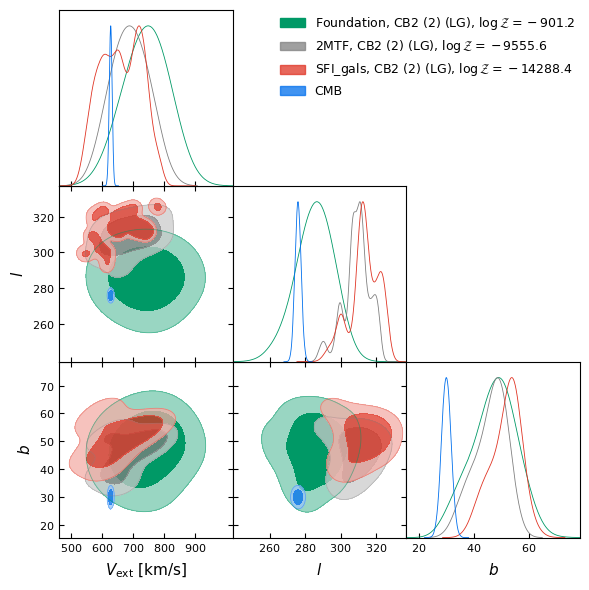

In [98]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")

X = [
    # LOSS_CB1,
    # LOSS_CB1_LG,
    # LOSS_CB2_0,
    # LOSS_CB2_LG,
    # FOUNDATION_CB2,
    FOUNDATION_CB2_LG,
    # FOUNDATION_CB1_LG,
    # PANTHEON_CB2,
    # PANTHEON_CB2_LG,
    # TWOMTF_CB1,
    # TWOMTF_CB1_LG,
    # TWOMTF_CB2,
    TWOMTF_CB2_LG,
    # SFIGAL_CB2,
    SFIGAL_CB2_LG,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
g.export(f"../plots/CB2_dipole.png", dpi=500,)